# Code for Running all Methods

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import Data_Processing as dp
import Feature_Engineering as fe

from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score, classification_report

## Functions

In [2]:
def normalize(X_train, X_test):
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, X_test

In [3]:
def evalPred(Y, Y_pred):
    acc = accuracy_score(Y, Y_pred)
    f1 = f1_score(Y, Y_pred, average='macro')
    prec = precision_score(Y, Y_pred, average='macro')
    rec = precision_score(Y, Y_pred, average='macro')
    confMat = confusion_matrix(Y, Y_pred)
    
    return {"accuracy": acc, "f1": f1, "precision": prec, "recall": rec, "confusion_matrix": confMat}

## Load in data

In [4]:
type = "base_player"
# type = "full" # use for high-dimensional and SVD-reduced settings
df = dp.read_prep_data(type)
X, Y = fe.feature_eng(df, type)

## Normalize and split into train and test

In [5]:
X_train, X_test, Y_train, Y_test= train_test_split(X, Y, train_size = 0.8, random_state=100)

In [6]:
X_train, X_test = normalize(X_train, X_test)

# Base, Balanced, High-dimensional Cases

## Decision Tree

In [8]:
dtclf = DecisionTreeClassifier() # class_weight='balanced' for balanced case
parameters = {'max_depth':[2,4,6,8,10,15,20,50]}
dt_cv = GridSearchCV(dtclf, parameters, cv=4)
dt_cv.fit(X_train, Y_train)
print("Best parameters:", dt_cv.best_params_)
print("Highest CV accuracy:", np.max(dt_cv.cv_results_['mean_test_score']))

dt_yhat = dt_cv.predict(X_test)
dt_eval_dict = evalPred(Y_test, dt_yhat)
print('Test accuracy:', dt_eval_dict['accuracy'])

Best parameters: {'max_depth': 4}
Highest CV accuracy: 0.4713784384323013
Test accuracy: 0.4697674418604651


## Random Forest

In [9]:
rfclf = RandomForestClassifier() # class_weight='balanced' for balanced case
parameters = {'max_depth':[2,5,10,15,20,25], 'n_estimators':[50,100,200,300]}
rf_cv = GridSearchCV(rfclf, parameters, cv=4)
rf_cv.fit(X_train, Y_train)

print("Best parameters:", rf_cv.best_params_)
print("Highest CV accuracy:", np.max(rf_cv.cv_results_['mean_test_score']))

rf_yhat = rf_cv.predict(X_test)
rf_eval_dict = evalPred(Y_test, rf_yhat)

Best parameters: {'max_depth': 25, 'n_estimators': 200}
Highest CV accuracy: 0.4863675221381377


## Logistic Regression

### No regularization

In [10]:
lrclf = LogisticRegression(penalty='none') # class_weight='balanced' for balanced case
lrclf.fit(X_train, Y_train)
lr_yhat = lrclf.predict(X_test)
eval_dict = evalPred(Y_test, lr_yhat)

### Ridge regularization

In [11]:
ridgeclf = LogisticRegression(penalty='l2') # class_weight='balanced' for balanced case
parameters = {'C': [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]}
ridge_cv = GridSearchCV(ridgeclf, parameters, cv=4)
ridge_cv.fit(X_train, Y_train)

print("Best parameters:", ridge_cv.best_params_)
print("Highest CV accuracy:", np.max(ridge_cv.cv_results_['mean_test_score']))

ridge_yhat = ridge_cv.predict(X_test)
ridge_eval_dict = evalPred(Y_test, ridge_yhat)

Best parameters: {'C': 0.001}
Highest CV accuracy: 0.4972865378617421


### LASSO regularization

In [12]:
lassoclf = LogisticRegression(penalty='l1', solver='liblinear') # class_weight='balanced' for balanced case
parameters = {'C': [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]}
lasso_cv = GridSearchCV(lassoclf, parameters, cv=4)
lasso_cv.fit(X_train, Y_train)

print("Best parameters:", lasso_cv.best_params_)
print("Highest CV accuracy:", np.max(lasso_cv.cv_results_['mean_test_score']))

lasso_yhat = lasso_cv.predict(X_test)
lasso_eval_dict = evalPred(Y_test, lasso_yhat)

Best parameters: {'C': 0.1}
Highest CV accuracy: 0.49773871754748367


### Elastic net

In [13]:
elnetclf = LogisticRegression(penalty='elasticnet', solver='saga') # class_weight='balanced' for balanced case
parameters = {'C': [1e-2, 1e-1, 1, 10], 'l1_ratio':[0, 0.25, 0.5, 0.75, 1]}
elnet_cv = GridSearchCV(elnetclf, parameters, cv=4)
elnet_cv.fit(X_train, Y_train)

print("Best parameters:", elnet_cv.best_params_)
print("Highest CV accuracy:", np.max(elnet_cv.cv_results_['mean_test_score']))

elnet_yhat = elnet_cv.predict(X_test)
elnet_eval_dict = evalPred(Y_test, elnet_yhat)

Best parameters: {'C': 0.01, 'l1_ratio': 0.5}
Highest CV accuracy: 0.5020674339128419


## SVM

In [62]:
svmclf = svm.SVC(decision_function_shape='ovr') # class_weight='balanced' for balanced case
parameters = {'C': [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]}
svm_cv = GridSearchCV(svmclf, parameters, cv=4)
svm_cv.fit(X_train, Y_train)

print("Best parameters:", svm_cv.best_params_)
print("Highest CV accuracy:", np.max(svm_cv.cv_results_['mean_test_score']))

yhat = svm_cv.predict(X_test)
eval_dict = evalPred(Y_test, yhat)

Best parameters: {'C': 1}
Highest CV accuracy: 0.4943788264633144


## XGBoost

In [81]:
xgbclf = XGBClassifier() # class_weight='balanced' for balanced case
parameters = {'max_depth': [2,3,4,5], 'n_estimators':[50, 100, 150, 200]}
xgb_cv = GridSearchCV(xgbclf, parameters, cv=4)
xgb_cv.fit(X_train, Y_train)

print("Best parameters:", xgb_cv.best_params_)
print("Highest CV accuracy:", np.max(xgb_cv.cv_results_['mean_test_score']))

yhat = xgb_cv.predict(X_test)
xgb_eval_dict = evalPred(Y_test, yhat)

Best parameters: {'max_depth': 2, 'n_estimators': 200}
Highest CV accuracy: 0.49418464398989387


## Principal Components Reduction of Full Data

In [63]:
svd = TruncatedSVD(n_components = 750)

In [64]:
svd.fit(X_train)

TruncatedSVD(n_components=750)

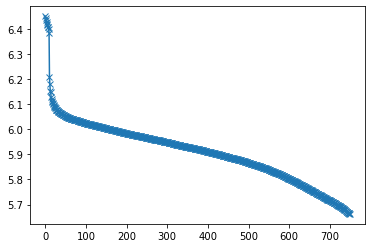

In [65]:
plt.plot(np.log(svd.singular_values_), label="Singular Value Magnitudes", marker = "x")

In [66]:
X_train_PCA = svd.transform(X_train)

In [67]:
X_test_PCA = svd.transform(X_test)

### Decision Tree

In [70]:
dtclf = DecisionTreeClassifier()
parameters = {'max_depth':[2,4,6,8,10,15,20,50]}
dt_cv = GridSearchCV(dtclf, parameters, cv=4)
dt_cv.fit(X_train_PCA, Y_train)
print("Best parameters:", dt_cv.best_params_)
print("Highest CV accuracy:", np.max(dt_cv.cv_results_['mean_test_score']))

dt_yhat = dt_cv.predict(X_test_PCA)
dt_eval_dict = evalPred(Y_test, dt_yhat)
print('Test accuracy:', dt_eval_dict['accuracy'])

Best parameters: {'max_depth': 2}
Highest CV accuracy: 0.47745175826135394
Test accuracy: 0.47674418604651164


### Random Forest

In [71]:
rfclf = RandomForestClassifier()
parameters = {'max_depth':[2,5,10,15,20,25], 'n_estimators':[50,100,200,300]}
rf_cv = GridSearchCV(rfclf, parameters, cv=4)
rf_cv.fit(X_train_PCA, Y_train)

print("Best parameters:", rf_cv.best_params_)
print("Highest CV accuracy:", np.max(rf_cv.cv_results_['mean_test_score']))

rf_yhat = rf_cv.predict(X_test_PCA)
rf_eval_dict = evalPred(Y_test, rf_yhat)
print('Test accuracy:', rf_eval_dict['accuracy'])

Best parameters: {'max_depth': 10, 'n_estimators': 200}
Highest CV accuracy: 0.49366811527125776
Test accuracy: 0.4901808785529716


### Logistic Regression (no regularization)

In [72]:
lrclf = LogisticRegression(penalty='none')
lrclf.fit(X_train_PCA, Y_train)
lr_yhat = lrclf.predict(X_test_PCA)
lr_eval_dict = evalPred(Y_test, lr_yhat)
print('Test accuracy:', lr_eval_dict['accuracy'])

Test accuracy: 0.5012919896640827


### Ridge Logistic Regression

In [73]:
ridgeclf = LogisticRegression(penalty='l2')
parameters = {'C': [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]}
ridge_cv = GridSearchCV(ridgeclf, parameters, cv=4)
ridge_cv.fit(X_train_PCA, Y_train)

print("Best parameters:", ridge_cv.best_params_)
print("Highest CV accuracy:", np.max(ridge_cv.cv_results_['mean_test_score']))

ridge_yhat = ridge_cv.predict(X_test_PCA)
ridge_eval_dict = evalPred(Y_test, ridge_yhat)
print('Test accuracy:', ridge_eval_dict['accuracy'])

Best parameters: {'C': 0.0001}
Highest CV accuracy: 0.4959294478138359
Test accuracy: 0.5111111111111111


### LASSO Logistic Regression

In [74]:
lassoclf = LogisticRegression(penalty='l1', solver='liblinear')
parameters = {'C': [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]}
lasso_cv = GridSearchCV(lassoclf, parameters, cv=4)
lasso_cv.fit(X_train_PCA, Y_train)

print("Best parameters:", lasso_cv.best_params_)
print("Highest CV accuracy:", np.max(lasso_cv.cv_results_['mean_test_score']))

lasso_yhat = lasso_cv.predict(X_test_PCA)
lasso_eval_dict = evalPred(Y_test, lasso_yhat)
print('Test accuracy:', lasso_eval_dict['accuracy'])

Best parameters: {'C': 0.01}
Highest CV accuracy: 0.5040051846553436
Test accuracy: 0.513953488372093


### Elastic Net Logistic Regression

In [75]:
elnetclf = LogisticRegression(penalty='elasticnet', solver='saga')
parameters = {'C': [1e-2, 1e-1, 1, 10], 'l1_ratio':[0, 0.25, 0.5, 0.75, 1]}
elnet_cv = GridSearchCV(elnetclf, parameters, cv=4)
elnet_cv.fit(X_train_PCA, Y_train)

print("Best parameters:", elnet_cv.best_params_)
print("Highest CV accuracy:", np.max(elnet_cv.cv_results_['mean_test_score']))

elnet_yhat = elnet_cv.predict(X_test_PCA)
elnet_eval_dict = evalPred(Y_test, elnet_yhat)
print('Test accuracy:', elnet_eval_dict['accuracy'])

Best parameters: {'C': 0.01, 'l1_ratio': 1}
Highest CV accuracy: 0.501614536269546
Test accuracy: 0.5157622739018087


### Support Vector Machine

In [76]:
svmclf = svm.SVC(decision_function_shape='ovr')
parameters = {'C': [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]}
svm_cv = GridSearchCV(svmclf, parameters, cv=4)
svm_cv.fit(X_train_PCA, Y_train)

print("Best parameters:", svm_cv.best_params_)
print("Highest CV accuracy:", np.max(svm_cv.cv_results_['mean_test_score']))

yhat = svm_cv.predict(X_test_PCA)
svm_eval_dict = evalPred(Y_test, yhat)
print('Test accuracy:', svm_eval_dict['accuracy'])

Best parameters: {'C': 1}
Highest CV accuracy: 0.49263440666318037
Test accuracy: 0.5049095607235142


### XGBoost

In [77]:
xgbclf = XGBClassifier()
parameters = {'max_depth': [2,3,4,5], 'n_estimators':[50, 100, 150, 200]}
xgb_cv = GridSearchCV(xgbclf, parameters, cv=4)
xgb_cv.fit(X_train_PCA, Y_train)

print("Best parameters:", xgb_cv.best_params_)
print("Highest CV accuracy:", np.max(xgb_cv.cv_results_['mean_test_score']))

yhat = xgb_cv.predict(X_test_PCA)
xgb_eval_dict = evalPred(Y_test, yhat)
print('Test accuracy:', xgb_eval_dict['accuracy'])

Best parameters: {'max_depth': 2, 'n_estimators': 100}
Highest CV accuracy: 0.49502528880260044
Test accuracy: 0.49844961240310076


## Hierarchical Classification

In [7]:
def create_nodes(X_train, Y_train):
    y_node1 = np.zeros(len(Y))
    y_node1[Y!=0] = 1
    X_node1 = X
    
    y_node2 = Y[Y > 0]
    y_node2[y_node2 == 1] = 0
    y_node2[y_node2 == 2] = 1
    X_node2 = X[Y > 0, :]
    
    return X_node1, y_node1, X_node2, y_node2

In [8]:
def HCPredict(clf_node1, clf_node2, X_test):
    pred_node1 = clf_node1.predict(X_test)
    X_node2 = X_test[pred_node1 == 1, :]
    
    pred_node2 = np.zeros((X_test.shape[0], 2))
    pred_node2[pred_node1 == 1, 0] = 1
    pred_node2[pred_node1 == 1, 1] = clf_node2.predict(X_node2)
    
    y_pred = np.ones(X_test.shape[0])
    y_pred[pred_node2[:,0]==0] = 0
    y_pred[pred_node2[:,1]==1] = 2
    
    return y_pred, pred_node1, pred_node2

In [50]:
def create_folds(X_train, Y_train):
    skf = StratifiedKFold(n_splits=4)
    i = 0
    for train_index, val_index in skf.split(X_train, Y_train):
        if (i == 0):
            X_train_0, X_val_0 = X[train_index], X[val_index]
            Y_train_0, Y_val_0 = Y[train_index], Y[val_index]
        elif (i==1):
            X_train_1, X_val_1 = X[train_index], X[val_index]
            Y_train_1, Y_val_1 = Y[train_index], Y[val_index]
        elif (i==2):
            X_train_2, X_val_2 = X[train_index], X[val_index]
            Y_train_2, Y_val_2 = Y[train_index], Y[val_index]
        elif (i==3):
            X_train_3, X_val_3 = X[train_index], X[val_index]
            Y_train_3, Y_val_3 = Y[train_index], Y[val_index]
        i = i+1
    return [(X_train_0, Y_train_0), (X_train_1, Y_train_1), (X_train_2, Y_train_2), (X_train_3, Y_train_3),
            (X_val_0, Y_val_0), (X_val_1, Y_val_1), (X_val_2, Y_val_2), (X_val_3, Y_val_3)]

#### Functions to fit and save classifiers with all hyperparameter grid choices

In [19]:
def fitDTClassifier(X_train, Y_train, depthList=[2,4,6,8,10,15,20]):
    classifierList = []
    for depth in depthList:
        clf = DecisionTreeClassifier(max_depth=depth)
        clf.fit(X_train, Y_train)
        classifierList.append(clf)
        print("Fit done")
    
    print("DT done")
    
    return classifierList

In [20]:
def fitRFClassifier(X_train, Y_train, depthList=[2,5,10,15,20,25], nEstimList=[50,100,200,300]) :
    classifierList = []
    for depth in depthList:
        for nEstim in nEstimList:
            clf = RandomForestClassifier(max_depth=depth, n_estimators=nEstim)
            clf.fit(X_train, Y_train)
            classifierList.append(clf)
            print("Fit done")
    
    print("RF done")
    
    return classifierList

In [21]:
def fitLRClassifier(X_train, Y_train, penalty, regList=[1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000],
                    alphaList=[0, 0.25, 0.5, 0.75, 1]):
    classifierList = []
    if (penalty=='none'):
        clf = LogisticRegression(penalty='none')
        clf.fit(X_train, Y_train)
        classifierList.append(clf)
        print("Fit done")
        print("LR done")
    elif (penalty=='l2'):
        for reg in regList:
            clf = LogisticRegression(penalty='l2', C=reg)
            clf.fit(X_train, Y_train)
            classifierList.append(clf)
            print("Fit done")
        print("LR done")
    elif (penalty=='l1'):
        for reg in regList:
            clf = LogisticRegression(penalty='l1', solver='liblinear', C=reg)
            clf.fit(X_train, Y_train)
            classifierList.append(clf)
            print("Fit done")
        print("LR done")
    elif (penalty=='elnet'):
        regList = [1e-2, 1e-1, 1, 10]
        for reg in regList:
            for alpha in alphaList:
                clf = LogisticRegression(penalty='elasticnet', solver='saga', C=reg, l1_ratio=alpha)
                clf.fit(X_train, Y_train)
                classifierList.append(clf)
                print("Fit done")
        print("LR done")
    
    return classifierList

In [18]:
def fitSVMClassifier(X_train, Y_train, regList=[1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]):
    classifierList = []
    for reg in regList:
        clf = svm.SVC(decision_function_shape='ovr', C=reg)
        clf.fit(X_train, Y_train)
        classifierList.append(clf)
        print("Fit done")
    print("SVM done")
    
    return classifierList

In [17]:
def fitXGBClassifier(X_train, Y_train, depthList=[2,3,4,5], nEstimList=[50, 100, 150, 200]):
    classifierList = []
    for depth in depthList:
        for nEstim in nEstimList:
            clf = XGBClassifier(max_depth=depth, n_estimators=nEstim)
            clf.fit(X_train, Y_train)
            classifierList.append(clf)
            print("Fit done")
    print("XGB done")
    
    return classifierList

In [30]:
def fitAllClassifiers(X_train, Y_train):
    classifierListNode1 = []
    classifierListNode2 = []
    foldList = create_folds(X_train, Y_train)
    
    # Nr. of folds is 4
    for i in range(4):
        X_node1, Y_node1, X_node2, Y_node2 = create_nodes(foldList[i][0], foldList[i][1])
        
        DTNode1 = fitDTClassifier(X_node1, Y_node1)
        RFNode1 = fitRFClassifier(X_node1, Y_node1)
        LRNode1 = fitLRClassifier(X_node1, Y_node1, penalty='none')
        RidgeNode1 = fitLRClassifier(X_node1, Y_node1, penalty='l2')
        LASSONode1 = fitLRClassifier(X_node1, Y_node1, penalty='l1')
        ElnetNode1 = fitLRClassifier(X_node1, Y_node1, penalty='elnet')
        SVMNode1 = fitSVMClassifier(X_node1, Y_node1)
        XGBNode1 = fitXGBClassifier(X_node1, Y_node1)
        
        classifierListNode1.append(DTNode1)
        classifierListNode1.append(RFNode1)
        classifierListNode1.append(LRNode1)
        classifierListNode1.append(RidgeNode1)
        classifierListNode1.append(LASSONode1)
        classifierListNode1.append(ElnetNode1)
        classifierListNode1.append(SVMNode1)
        classifierListNode1.append(XGBNode1)
        
        DTNode2 = fitDTClassifier(X_node2, Y_node2)
        RFNode2 = fitRFClassifier(X_node2, Y_node2)
        LRNode2 = fitLRClassifier(X_node2, Y_node2, penalty='none')
        RidgeNode2 = fitLRClassifier(X_node2, Y_node2, penalty='l2')
        LASSONode2 = fitLRClassifier(X_node2, Y_node2, penalty='l1')
        ElnetNode2 = fitLRClassifier(X_node2, Y_node2, penalty='elnet')
        SVMNode2 = fitSVMClassifier(X_node2, Y_node2)
        XGBNode2 = fitXGBClassifier(X_node2, Y_node2)
        
        classifierListNode2.append(DTNode2)
        classifierListNode2.append(RFNode2)
        classifierListNode2.append(LRNode2)
        classifierListNode2.append(RidgeNode2)
        classifierListNode2.append(LASSONode2)
        classifierListNode2.append(ElnetNode2)
        classifierListNode2.append(SVMNode2)
        classifierListNode2.append(XGBNode2)
    
    return foldList, classifierListNode1, classifierListNode2

In [29]:
def fitErrorClassifiers(X_train, Y_train):
    classifierListNode1 = []
    classifierListNode2 = []
    foldList = create_folds(X_train, Y_train)
    
    # Nr. of folds is 4
    for i in range(4):
        X_node1, Y_node1, X_node2, Y_node2 = create_nodes(foldList[i][0], foldList[i][1])
        
        ElnetNode1 = fitLRClassifier(X_node1, Y_node1, penalty='elnet')
        XGBNode1 = fitXGBClassifier(X_node1, Y_node1)
        
        classifierListNode1.append(ElnetNode1)
        classifierListNode1.append(XGBNode1)

        ElnetNode2 = fitLRClassifier(X_node2, Y_node2, penalty='elnet')
        XGBNode2 = fitXGBClassifier(X_node2, Y_node2)

        classifierListNode2.append(ElnetNode2)
        classifierListNode2.append(XGBNode2)
    
    return foldList, classifierListNode1, classifierListNode2

In [60]:
def validateAllClassifiers(foldList, classifierListNode1, classifierListNode2):
    clfsNode1 = []
    clfsNode2 = []
    
    for clfType in classifierListNode1:
        for i in range(len(clfType)):
            clfsNode1.append(clfType[i])
    
    for clfType in classifierListNode2:
        for i in range(len(clfType)):
            clfsNode2.append(clfType[i])
            
    validationScores = np.zeros((len(clfsNode1)*len(clfsNode2)))
    
    nD = int(len(clfsNode1)/4)
    
    for i in range(nD):
        for j in range(nD):
            acc = 0
            for k in range(4):
                clf1 = clfsNode1[i+k*nD]
                clf2 = clfsNode2[i+k*nD]
                X_val, Y_val = foldList[k+4]
                Y_pred, _, _ = HCPredict(clf1, clf2, X_val)
                acc += accuracy_score(Y_val, Y_pred)
            validationScores[i+j*nD] = acc/4
        print(i)
            
    return validationScores

In [61]:
folds = create_folds(X_train, Y_train)

### Run Hierarchical Classification

In [ ]:
valScores = validateAllClassifiers(folds, clfListNode1All, clfListNode2All)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69


In [28]:
foldsList, clfListNode1, clfListNode2 = fitAllClassifiers(X_train, Y_train)

Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
DT done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
RF done
Fit done
LR done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
LR done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
LR done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
SVM done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
DT done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
RF done
Fit done
LR done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
LR done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
F

In [31]:
foldsListAll, clfListNode1All, clfListNode2All = fitAllClassifiers(X_train, Y_train)

Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
DT done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
RF done
Fit done
LR done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
LR done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
LR done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
LR done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
SVM done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
XGB done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
Fit done
DT done
Fit done
Fit done
Fit done
Fit done
Fit done